In [3]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


plt.style.use("dark_background")

# The importance of featurization: representing a time series dataset

Let's prepare a more dynamical dataset, consisting of a set of time series sampled from one of several distinct sets of chaotic low-dimensional dynamical systems. For simplicity, our dataset consists of just the x coordinate of trajectories initialized at many different initial conditions

In [4]:
def lorenz(t, X):
    """Lorenz system."""
    x, y, z = X
    return np.array([10 * (y - x), x * (28 - z) - y, x * y - (8 / 3) * z])

def rossler(t, X):
    """Rossler system."""
    x, y, z = X
    return np.array([-y - z, x + 0.2 * y, 0.2 + z * (x - 14)]) * 3


def halvorsen(t, X, a=1.4, b=4):
    """Halvorsen system."""
    x, y, z = X
    xdot = -a * x - b * (y + z) - y ** 2
    ydot = -a * y - b * (z + x) - z ** 2
    zdot = -a * z - b * (x + y) - x ** 2
    return np.array([xdot, ydot, zdot])

def thomas(t, X, a=1.85, b=10):
    """Thoma's cyclic attractor."""
    x, y, z = X
    xdot = -a * x + b * np.sin(y)
    ydot = -a * y + b * np.sin(z)
    zdot = -a * z + b * np.sin(x)
    return np.array([xdot, ydot, zdot]) * 2






from scipy.integrate import solve_ivp

np.random.seed(0)
ic = np.random.random((50, 3))
t = np.linspace(0, 100, 10000)

X_train_raw, y_train = list(), list()
for i, rhs in enumerate([lorenz, rossler, halvorsen, thomas]):
    all_sol = list()
    for y0 in ic:
        sol = solve_ivp(rhs, [t[0], t[-1]], y0, t_eval=t, method='RK45')
        all_sol.append(sol.y.T.copy())
    all_sol = np.array(all_sol)[:, -1000:] # discard transient
    X_train_raw.append(all_sol) 
    y_train.append(i * np.ones(all_sol.shape[0]))

X_train = np.concatenate([X_train_raw[i][:, :, 0] for i in range(len(X_train_raw))], axis=0) # keep just x component
y_train = np.concatenate(y_train, axis=0).astype(int)

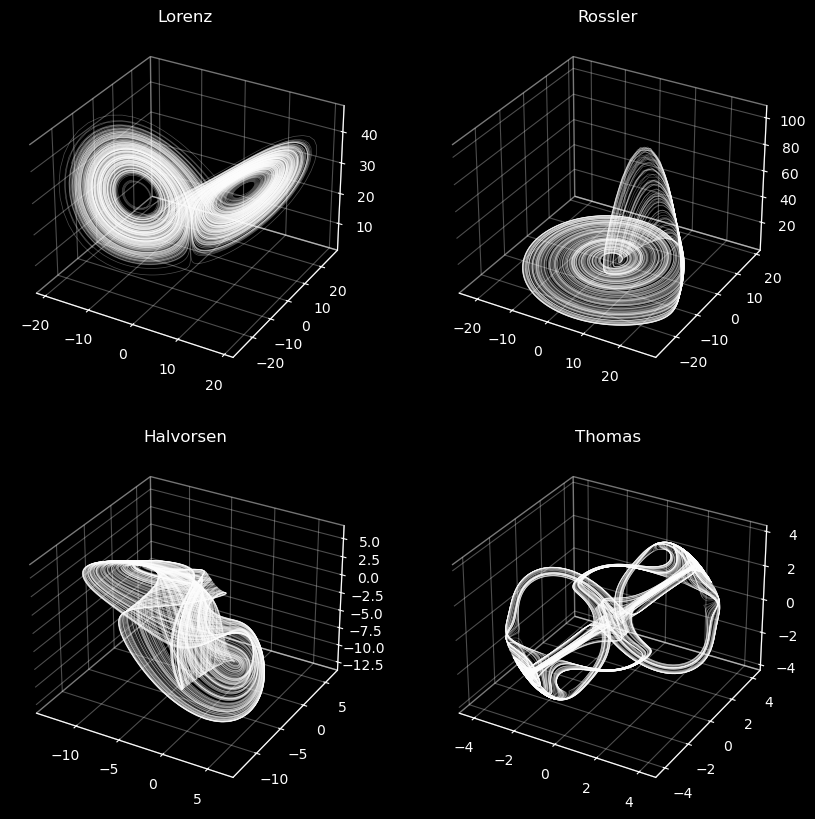

In [16]:
## Visualize the data

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
for i in range(len(X_train_raw)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    for j in range(X_train_raw[i].shape[0]):
        ax.plot(X_train_raw[i][j, :, 0], X_train_raw[i][j, :, 1], X_train_raw[i][j, :, 2], color='w', linewidth=0.5, alpha=0.3);
    ax.set_title(['Lorenz', 'Rossler', 'Halvorsen', 'Thomas'][i])

    # shadows on axes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # darken grid lines
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1, 0.3)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1, 0.3)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1, 0.3)

    #ax.plot(X_train_raw[i][..., 0], X_train_raw[i][..., 1], X_train_raw[i][..., 2], label=f'Class {i}')


## Embedding this dataset

+ Our individual time series each have $1000$ timepoints, and we have $50$ time series per initial condition per system.
+ If we think of individual timepoints as **features**, then we have a high-dimensional dataset
+ Let's try to embed this dataset using PCA

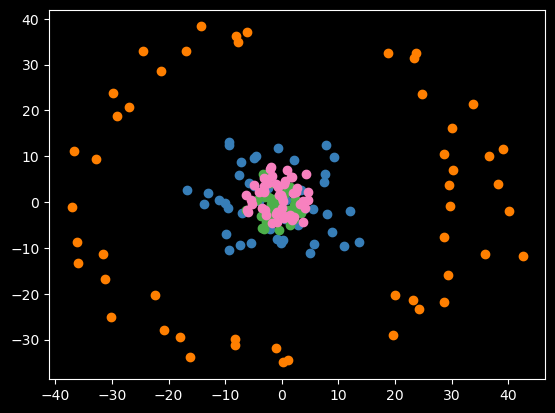

In [17]:
## Reduce dimensionality

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import islice, cycle

pca = PCA(n_components=2)
X_train = StandardScaler().fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train)

## Visualize the data
plt.figure()
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00']), int(max(y_train) + 1))))  # color for each class
for i in np.unique(y_train):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1], color=colors[i])



## Why does PCA fail?

+ The PCA embedding is not very informative. Clearly the difference between distinct dynamical systems cannot be expressed simply as a linear combination of timepoints 
+ What if we try nonlinear dimensionality reduction methods like t-SNE or UMAP? These will embed in fewer dimensions using nonlinear combinations of points


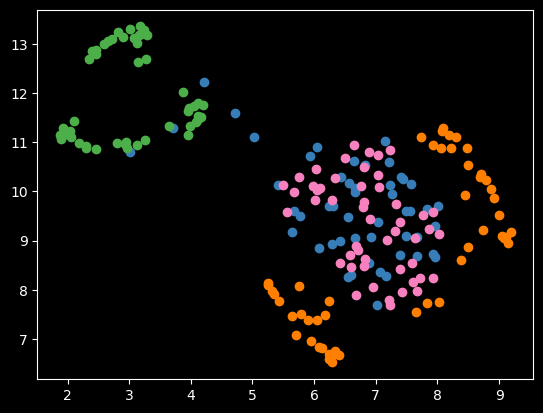

In [20]:
import umap

reducer = umap.UMAP(random_state=0)
X_train_umap = reducer.fit_transform(X_train)

## Visualize the data
plt.figure()
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00'])
                                , int(max(y_train) + 1))))  # color for each class  
for i in np.unique(y_train):
    plt.scatter(X_train_umap[y_train == i, 0], X_train_umap[y_train == i, 1], color=colors[i])

# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")


## Can we use our domain knowledge to help us?

+ What exactly are we trying to do here? We want to cluster the time series into distinct dynamical systems. Currently, our features are the individual timepoints.
+ What happens if we shift the features? Or remove the first 100 timepoints? We still have a valid feature vector for each time series, but the features will be seen as different by the embedding algorithms
+ In other words, whether a time series belongs to a given system is *time translation invariant*
+ We want our features to be independent "digests" that describe different global properties of the underlying dynamical systems. Can we use our physical knowledge to choose better features?

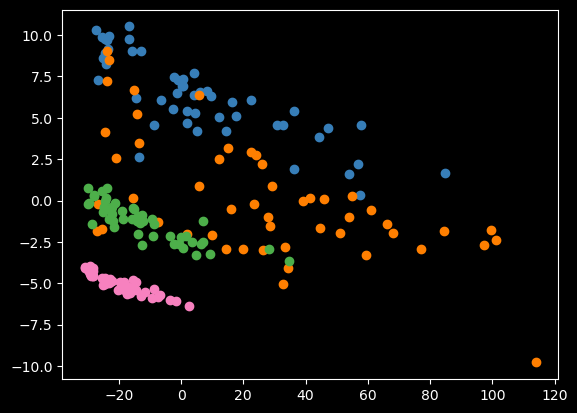

In [21]:
X_train_fft = np.fft.fft(X_train, axis=1)
X_train_fft = np.abs(X_train_fft) # keep just the amplitude. Phases shouldnt matter, since whether 
X_train_fft = X_train_fft[:, 1:1000] # discard the first component, which is just the mean




from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_fft = StandardScaler().fit_transform(X_train_fft) # standardize features to zero mean and unit variance
X_train_fft_pca = pca.fit_transform(X_train_fft)

## Visualize the data

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00'])
                                , int(max(y_train) + 1))))  # color for each class  
plt.figure()
for i in np.unique(y_train):
    plt.scatter(X_train_fft_pca[y_train == i, 0], X_train_fft_pca[y_train == i, 1], color=colors[i])


## Can we choose a better featurization?

+ We want each feature to be a digest of the entire time series. We want features to tell us as much independent information as possible about the underlying dynamical system.
+ Fourier coefficients were a good choice, but they clearly don't capture all the information in the time series. What other features could we use?
+ Various ideas: autocorrelation, entropy, Lyapunov exponents, etc.
+ Why not use many random integral transforms? See [Dempster et al. (2019)](https://arxiv.org/abs/1910.13051) for a discussion of this idea.


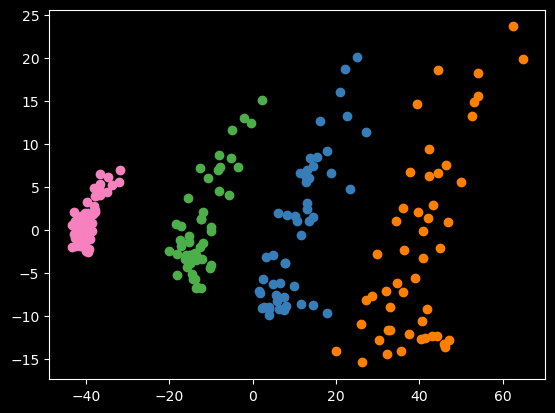

In [44]:
def rocket_features(x, n_kernels=100, kernel_size=9):
    """Perform random convolutions of a time series with a random filter. 
    See Dempster et al. 2019 for details more information
    
    Args:
        x (np.ndarray): time series of shape (n_samples, n_timesteps)

    Returns:
        np.ndarray: features of shape (n_samples, n_features)
    """
    n_timesteps = x.shape[1]
    kernels = np.random.randn(n_kernels, kernel_size)
    kernels /= np.linalg.norm(kernels, axis=1)[:, None]

    # pad the time series with zeros to avoid edge effects
    x = np.pad(x, ((0, 0), (kernel_size // 2, kernel_size // 2)), mode='constant')

    # convolve the time series with the all of the kernels, resulting in a tensor of 
    # shape (n_samples, n_kernels, n_timesteps)
    conv = np.zeros((x.shape[0], n_kernels, n_timesteps)) # preallocate
    for i in range(n_timesteps):
        conv[:, :, i] = x[:, i:i+kernel_size] @ kernels.T

    # Contract out time dimension by finding maximum response across any kernel, 
    # resulting in a tensor of shape (n_samples, n_kernels)
    conv = np.abs(conv)
    conv = np.max(conv, axis=2) 
    return conv

X_train_rocket = rocket_features(X_train)
X_train_rocket = StandardScaler().fit_transform(X_train_rocket)

## Visualize the data
pca = PCA(n_components=2)
X_train_rocket_pca = pca.fit_transform(X_train_rocket)

plt.figure()
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf',  '#999999', '#e41a1c', '#dede00'])
                                , int(max(y_train) + 1))))  # color for each class
for i in np.unique(y_train):
    plt.scatter(X_train_rocket_pca[y_train == i, 0], X_train_rocket_pca[y_train == i, 1], color=colors[i])